# Circular variables

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns
import math

import latenta as la

la.logger.setLevel("INFO")

## Transformation of a circular variable

A circular variable is defined as a variable that "wraps around". To model this in an unconstrained space, we can convert this variable to two orthogonal cartesian coordinates.

In [2]:
n_samples = 150
sample_ids = [str(i) for i in range(n_samples)]
sample_index = pd.Series(sample_ids, name="cell")

angle_value = pd.Series(
    np.linspace(0.0, (2.0 * np.pi), n_samples) % (2 * math.pi), index=sample_index
)
angle = la.Fixed(
    angle_value,
    label="angle",
    symbol=r"\theta",
)
angle

angle:  ↦ Fixed [cell (150)]

In [3]:
cartesian = la.links.scalar.Cartesian(angle, label="cartesian")
cartesian

cartesian: x ↦ Cartesian [cell (•), axis (2)] = $\left[ cos(\theta)\;\;sin(\theta) \right]\require{action}$

In [4]:
angle2 = la.links.vector.Circular(cartesian, label="the same angle", symbol=r"\theta 2")
angle2

the same angle: x ↦ Circular [cell (•)] = $\mathregular{atan2}(\mathregular{ cartesian })\require{action}$

In [5]:
angle2.plot()

In [6]:
assert torch.allclose(angle.prior(), angle2.prior())

## Transforming a normal distribution to sample circular values

In [7]:
coordinates = la.Fixed(
    pd.DataFrame(
        [[1.0, 0.0], [2.0, 0.0], [0.0, 1.0], [-1.0, 0.0], [0.0, -1.0]],
        index=pd.Series([0, "0bis", 90, 180, 270], name="angles"),
        columns=pd.Series(["x", "y"], name="axis"),
    )
)
dist1_untransformed = la.distributions.Normal(coordinates, scale=0.5)
dist1 = la.links.vector.Circular(dist1_untransformed)

  0%|          | 0/200 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Frequency'>

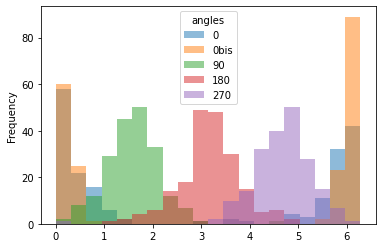

In [8]:
posterior = la.posterior.Posterior(dist1)
posterior.sample(200)

posterior.samples[dist1].to_pandas().plot(kind="hist", bins=20, alpha=0.5)

Correction of the likelihood
In this case, because the transformation is not bijective, the inverse likelihoods are not corrected.

In [9]:
dist1.reset()
dist1.run()
dist1.x.value = coordinates.prior()
uncorrected_likelihood = dist1.x.likelihood.sum(-1)
corrected_likelihood = dist1.likelihood

print(corrected_likelihood - uncorrected_likelihood)

tensor([0.0000, 0.6931, 0.0000, 0.0000, 0.0000])


Alternative, assigning the transformation directly to the variable

In [10]:
coordinates.value_definition

??: Definition [angles (5), axis (2)]

In [11]:
dist2 = la.distributions.Normal(
    coordinates, scale=0.5, transforms=[la.transforms.Circular()]
)

## Generative model

In [12]:
n_genes = 100
gene_ids = [str(i) for i in range(n_genes)]
genes = la.Dim(pd.Series(gene_ids, name="gene"))

beta = la.Fixed(
    pd.Series(np.random.uniform(-3, 3, n_genes), index=genes.index), label="beta"
)
shift = la.Fixed(
    pd.Series(np.random.uniform(0.0, 2 * np.pi, n_genes), index=genes.index),
    label="shift",
)
scale = la.Fixed(
    pd.Series(np.random.uniform(0.2, 2.0, n_genes), index=genes.index), label="scale"
)

In [13]:
y = la.links.scalar.Sine(x=angle, a=beta, shift=shift)

In [14]:
dist = la.distributions.Normal(loc=y, scale=scale)

In [15]:
dist.plot()

<AxesSubplot:>

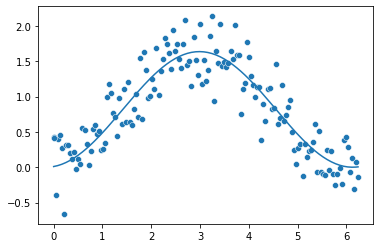

In [16]:
sns.lineplot(x=angle.prior().numpy(), y=y.prior()[:, 0].numpy())
sns.scatterplot(x=angle.prior().numpy(), y=dist.prior()[:, 0].numpy())

In [17]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

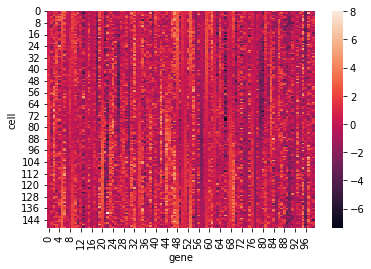

In [18]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
sns.heatmap(observation_value)

## Bayesian modelling

In [19]:
x = la.Latent(la.distributions.CircularUniform(), definition=angle)

In [20]:
x.plot()

In [21]:
output_definition = la.Definition.from_xr(observation_value)
output_definition

??: Definition [cell (150), gene (100)]

In [22]:
s_dist = la.distributions.LogNormal(1.0, 0.5)
s = la.Latent(s_dist, definition=la.Definition(), label="scale")

In [23]:
z = la.links.scalar.Sine(
    x,
    a=la.Latent(la.distributions.Normal(), definition=beta),
    shift=la.Latent(la.distributions.CircularUniform(), definition=shift),
    output=output_definition,
    b=True,
)

In [24]:
z = la.links.scalar.CircularSpline(x, output=output_definition, b=True)

In [25]:
z.empirical = xr.DataArray(observation_value)

In [26]:
dist2 = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist2, label="observation")

In [27]:
observation.plot()

In [28]:
model = la.Root(observation)

In [29]:
inference = la.infer.svi.SVI(
    model,
    [la.infer.loss.ELBO()],
    la.infer.optim.Adam(lr=0.01),
    subsamplers={"cell": la.infer.subsampling.Subsampler(50)},
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)

  0%|                                                                                                         …

In [48]:
observed = la.posterior.Observed(observation, retain_samples = {observation.p, x, z.b, z.a})
observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

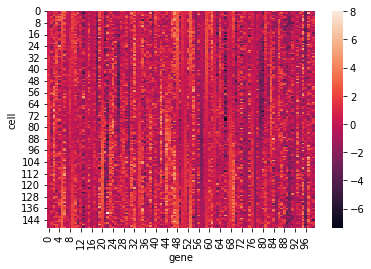

In [49]:
sns.heatmap(observation_value)

<AxesSubplot:xlabel='gene', ylabel='cell'>

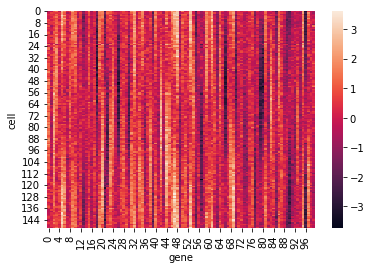

In [50]:
modelled_value = observed.samples[observation.p].mean("sample").to_pandas()
sns.heatmap(modelled_value)

<AxesSubplot:>

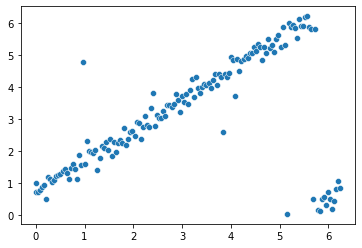

In [51]:
sns.scatterplot(
    x=angle.prior_pd(),
    y=la.domains.circular.mean(observed.samples[x], "sample").to_pandas(),
)

<AxesSubplot:>

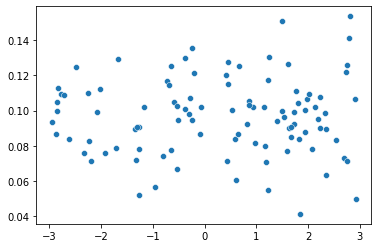

In [52]:
sns.scatterplot(x=beta.prior_pd(), y=observed.samples[z.b].mean("sample").to_pandas())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

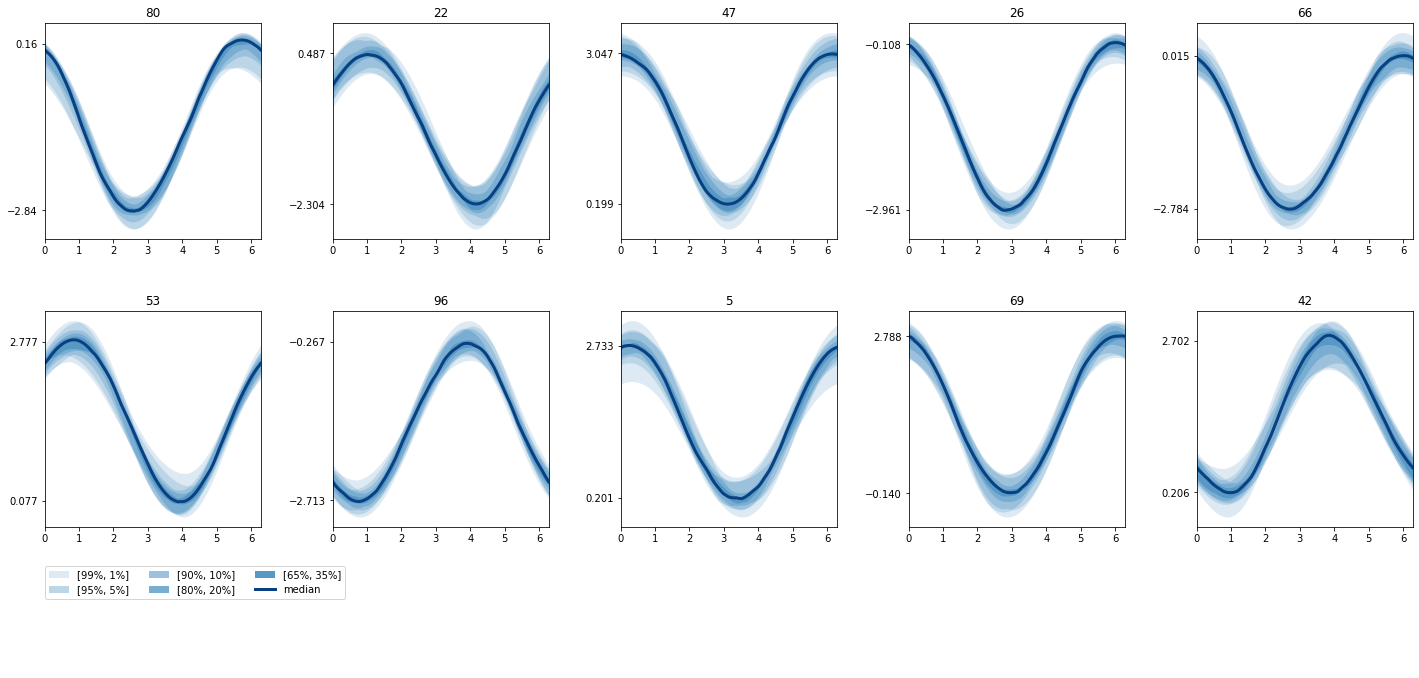

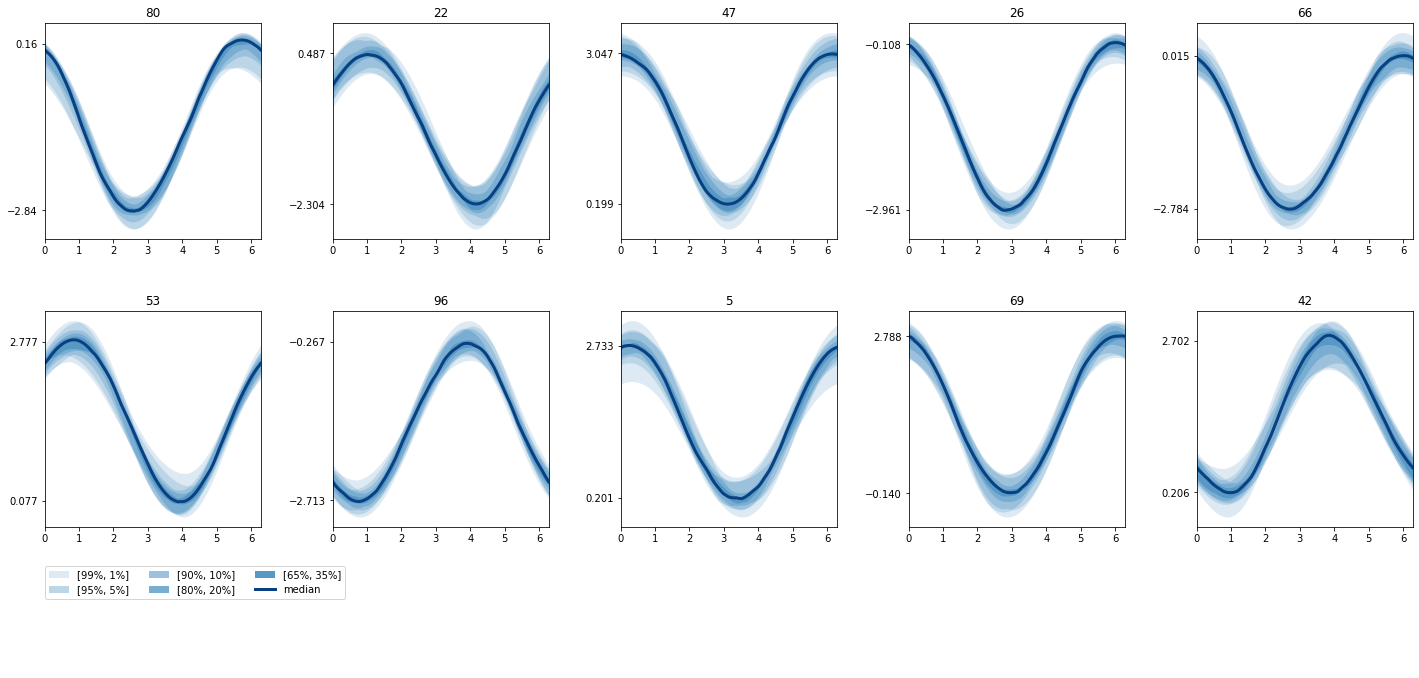

In [53]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(20)
causal.sample_bootstrap(10)
causal.plot_features()

## Amortization

In [55]:
encoder = la.amortization.Encoder(la.Fixed(observation_value, label="observed"), x)

In [56]:
observation.plot()

In [57]:
model = la.Root(observation)

In [58]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [61]:
posterior = la.posterior.Posterior(observation, retain_samples = {x})
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

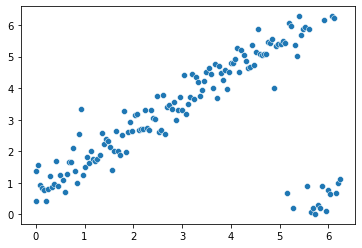

In [62]:
sns.scatterplot(x=angle.prior_pd(), y=posterior.samples[x].mean("sample").to_pandas())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

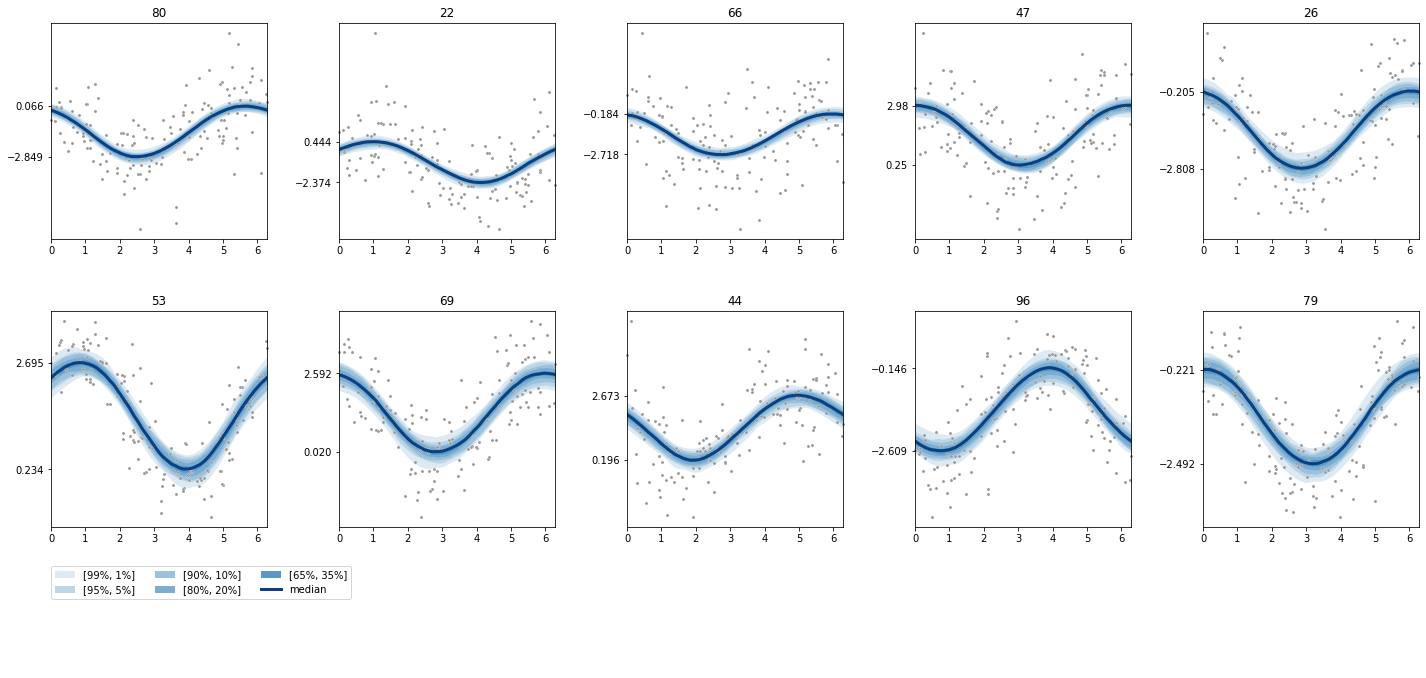

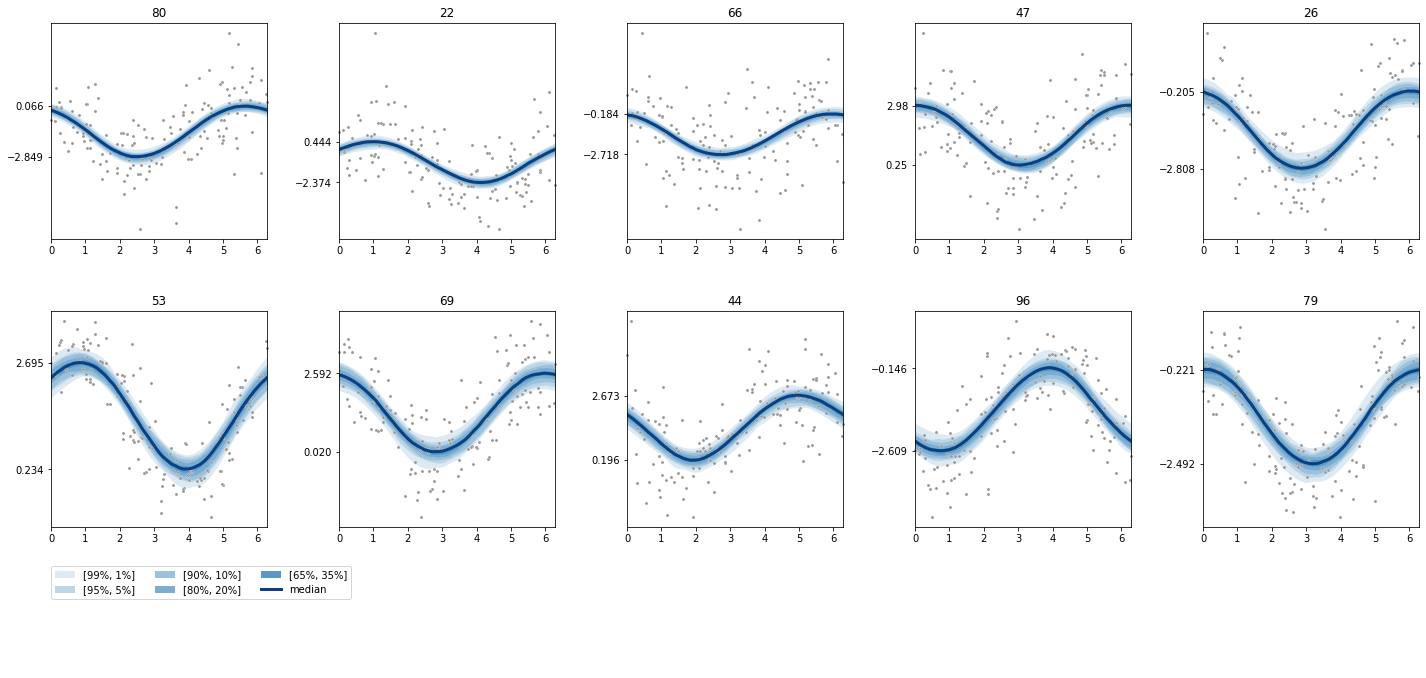

In [64]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.observed.sample(1)
causal.sample(100)
causal.sample_bootstrap(10)
causal.sample_empirical()
causal.plot_features(interpretable=observation.p.loc)